<a href="https://colab.research.google.com/github/francescopatane96/Computer_aided_drug_discovery_kit/blob/main/4_ligand_based_screening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. Ligand-based screening

In this tutorial we explore different approaches to encode and compare molecules. The encoding is performed with descriptors and fingerprints while the successive comparison is performed using similarity measures.

Theory

- molecular similarity: well known concept to compare molecules and their properties for the identification of new molecules with desired properties and biological activity.
There are two approaches, the similar property principle (SPP) and the structure-activity relationship (SAR). They are based on the concept that structurally similar compounds have similar properties and similar biological activity.

- molecular descriptors: similarity can be assessed in different ways, for examples using 1D molecular descriptors (solubility, logP, MW, melting point), 2D molecular descriptors (molecular graphs, paths, fragments, atom environments), 3D molecular descriptors (shape, stereochemistry).

While the 1D approach use global descriptors and doesn't contain enough information to apply ML approaches, the 2D technique is a detailed representation of individual parts of the molecule and is often used with ML. 3D descriptors are less robust than 2D counterpart because of molecule flexibility.

We already oibtained 1D physicochemical descriptors like the molecular weight (MW) and logP.

Remember that 2D descriptors are also called fingerprints due to their uniqueness per molecule.

- molecular substructure-based fingerprints: computational representation of molecules that encode chemical and molecular features in the form of bitstrings, bitvectors or arrays. Each bit corresponds to a predefined molecular feature or environment, where “1” represents the presence and “0” the absence of a feature. Note that some implementations are count-based. Thus, they count how often a specific feature is present.

There exist multiple ways to calculate fingerprints: MACCS keys and Morgan fingerprint.

1. MACCS fingerprint: Molecular ACCess System (MACCS) fingerprints, also termed MACCS structural keys, consist of 166 predefined structural fragments. Each position queries the presence or absence of one particular structural fragment or key. The individual keys were empirically defined by medicinal chemists and are simple to use and interpret;
2. Morgan circular fingerprints: The bits correspond to the circular environments of each atom in a molecule. The number of neighboring bonds and atoms to consider is set by the radius. Also the length of the bit string can be defined, a longer bit string will be modded to the desired length. Therefore, the Morgan fingerprint is not limited to a certain number of bits. There also exist some Morgan's variants like as Extended conncectivity fingerprints (ECFP).

- Molecular similarity measures: Once the descriptors/fingerprints are calculated, they can be compared to assess the similarity between two molecules. Molecular similarity can be quantified with a number of different similarity coefficients, two common similarity measures are the Tanimoto and Dice index. he similarity measures usually consider the number of positive bits (1’s) present in either fingerprint and the number of positive bits that both have in common.

- virtual screening: The challenge in early stages of drug discovery is to narrow down a set of small molecules (molecules) from the large existing chemical space that are potentially binding to the target under investigation. Note that this chemical space is vast: Small molecules can be made of 1020 combinations of chemical moieties. The process is called virtual (high-throughput) screening: a large library of small molecules is filtered by rules and/or patterns, in order to identify those small molecules that are most likely to bind a target under investigation.

- virtual screening using similarity search: Comparing a set of novel molecules against a (or several) known active molecule(s) to find the most similar ones can be used as a simple way of virtual screening. Given the similar property principle, we can assume that the most similar molecules, e.g. to a known inhibitor, also have similar effects. A similarity search can be performed by calculating the similarity between one molecule and all molecules in a specific dataset. Ranking the molecules of the dataset by their similarity coefficient yields the most similar molecules at the top.

- enrichment plots: used to validate virtual screening results, which display the ratio of active molecules detected in the top x% of the ranked list

In [ ]:
!pip install rdkit

In [2]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import (
    PandasTools,
    Draw,
    Descriptors,
    MACCSkeys,
    rdFingerprintGenerator,
)

## Import and draw compounds

In [3]:
# Molecules in SMILES format
molecule_smiles = [
    "CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O",
    "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C(=O)O)C",
    "C1=COC(=C1)CNC2=CC(=C(C=C2C(=O)O)S(=O)(=O)N)Cl",
    "CCCCCCCCCCCC(=O)OCCOC(=O)CCCCCCCCCCC",
    "C1NC2=CC(=C(C=C2S(=O)(=O)N1)S(=O)(=O)N)Cl",
    "CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C",
    "CC1(C2CC3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O",
    "CC1C(CC(=O)C2=C1C=CC=C2O)C(=O)O",
]

# List of molecule names
molecule_names = [
    "Doxycycline",
    "Amoxicilline",
    "Furosemide",
    "Glycol dilaurate",
    "Hydrochlorothiazide",
    "Isotretinoin",
    "Tetracycline",
    "Hemi-cycline D",
]

,smiles,name,ROMol
0,CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Doxycycline,
1,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,Amoxicilline,

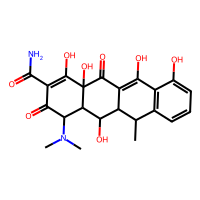
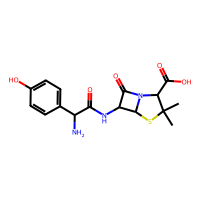

In [5]:
molecules = pd.DataFrame({"smiles": molecule_smiles, "name": molecule_names})
PandasTools.AddMoleculeColumnToFrame(molecules, smilesCol="smiles")
PandasTools.RenderImagesInAllDataFrames(True)
# Show first 2 molecules
molecules.head(2)

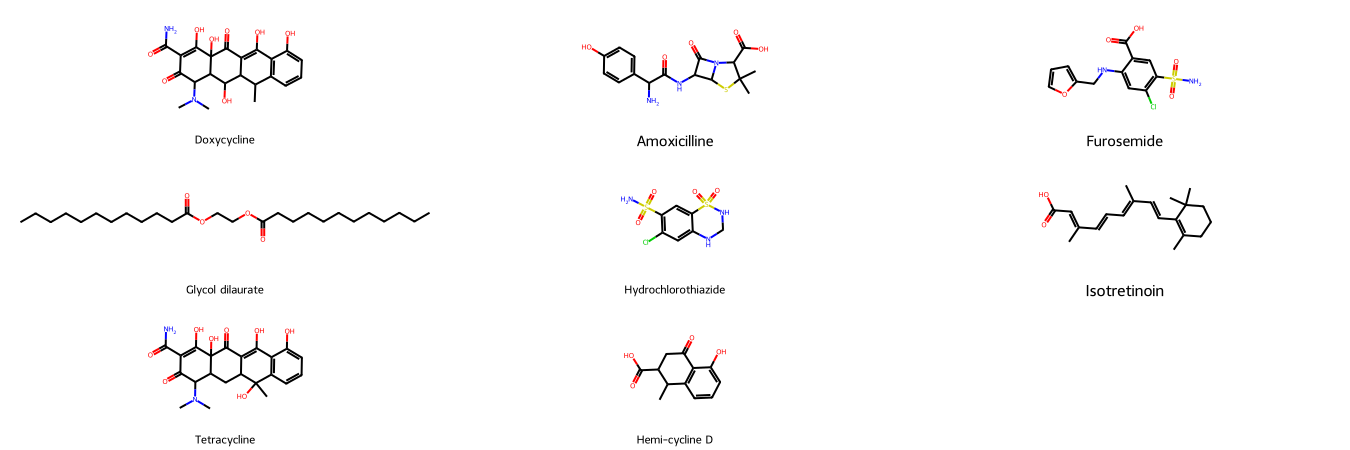

In [6]:
Draw.MolsToGridImage(
    molecules["ROMol"].to_list(),
    molsPerRow=3,
    subImgSize=(450, 150),
    legends=molecules["name"].to_list(),
)

## Calculate molecular descriptors

- 1D descriptors

In [7]:
# Note -- we use pandas apply function to apply the MolWt function
# to all ROMol objects in the DataFrame
molecules["molecule_weight"] = molecules.ROMol.apply(Descriptors.MolWt)
# Sort molecules by molecular weight
molecules.sort_values(["molecule_weight"], ascending=False, inplace=True)

In [8]:
# Show only molecule names and molecular weights
molecules[["smiles", "name", "molecule_weight"]]

,smiles,name,molecule_weight
0,CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Doxycycline,444.440
6,CC1(C2CC3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Tetracycline,444.440
3,CCCCCCCCCCCC(=O)OCCOC(=O)CCCCCCCCCCC,Glycol dilaurate,426.682
1,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,Amoxicilline,365.411
2,C1=COC(=C1)CNC2=CC(=C(C=C2C(=O)O)S(=O)(=O)N)Cl,Furosemide,330.749
5,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C,Isotretinoin,300.442
4,C1NC2=CC(=C(C=C2S(=O)(=O)N1)S(=O)(=O)N)Cl,Hydrochlorothiazide,297.745
7,CC1C(CC(=O)C2=C1C=CC=C2O)C(=O)O,Hemi-cycline D,220.224


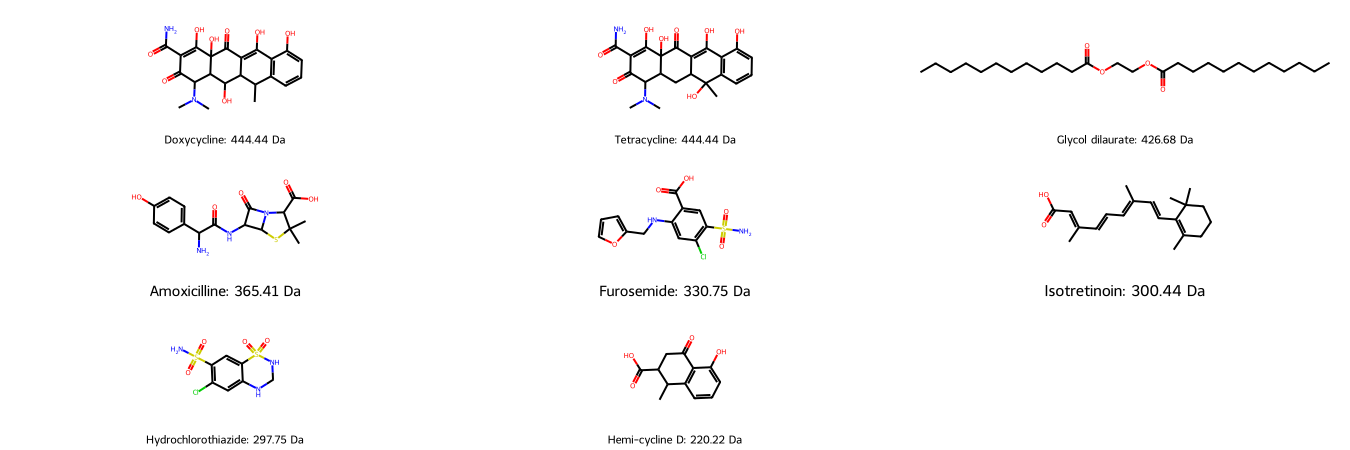

In [9]:
Draw.MolsToGridImage(
    molecules["ROMol"],
    legends=[
        f"{molecule['name']}: {molecule['molecule_weight']:.2f} Da"
        for index, molecule in molecules.iterrows()
    ],
    subImgSize=(450, 150),
    molsPerRow=3,
)

- 2D descriptors: MACCS fingerprint

In [13]:
molecules["maccs"] = molecules.ROMol.apply(MACCSkeys.GenMACCSKeys)

- 2D descriptors: Morgan fingerprint

In [15]:
molecules["morgan"] = molecules["ROMol"].map(fpg.GetFingerprint)

## Calculate molecular similarity

 we will apply two similarity measures, i.e. Tanimoto and Dice, to our two fingerprint types, i.e. MACCS and Morgan fingerprints.
 In the following, we want to compare a query molecule with our molecule list. Therefore, we use BulkTanimotoSimilarity and BulkDiceSimilarity from rdkit that calculate the similarity of a query fingerprint with a list of fingerprints, based on a similarity measure. We will investigate all combinations of MACCS/Morgan fingerprint comparisons based on the Tanimoto/Dice similarity measure.

- MACCS fingerprints: Tanimoto similarity and Dice similarity

In [16]:
# Define molecule query and list
molecule_query = molecules["maccs"][0]
molecule_list = molecules["maccs"].to_list()
# Calculate similarty values between query and list elements
molecules["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(molecule_query, molecule_list)
molecules["dice_maccs"] = DataStructs.BulkDiceSimilarity(molecule_query, molecule_list)

In [17]:
preview = molecules.sort_values(["tanimoto_maccs"], ascending=False).reset_index()
preview[["name", "tanimoto_maccs", "dice_maccs"]]
# NBVAL_CHECK_OUTPUT

,name,tanimoto_maccs,dice_maccs
0,Doxycycline,1.000000,1.000000
1,Tetracycline,0.928571,0.962963
2,Amoxicilline,0.590909,0.742857
3,Hemi-cycline D,0.403509,0.575000
4,Furosemide,0.321839,0.486957
5,Hydrochlorothiazide,0.306818,0.469565
6,Isotretinoin,0.288136,0.447368
7,Glycol dilaurate,0.149254,0.259740


In [18]:
def draw_ranked_molecules(molecules, sort_by_column):
    """
    Draw molecules sorted by a given column.

    Parameters
    ----------
    molecules : pandas.DataFrame
        Molecules (with "ROMol" and "name" columns and a column to sort by.
    sort_by_column : str
        Name of the column used to sort the molecules by.

    Returns
    -------
    Draw.MolsToGridImage
        2D visualization of sorted molecules.
    """

    molecules_sorted = molecules.sort_values([sort_by_column], ascending=False).reset_index()
    return Draw.MolsToGridImage(
        molecules_sorted["ROMol"],
        legends=[
            f"#{index+1} {molecule['name']}, similarity={molecule[sort_by_column]:.2f}"
            for index, molecule in molecules_sorted.iterrows()
        ],
        molsPerRow=3,
        subImgSize=(450, 150),
    )

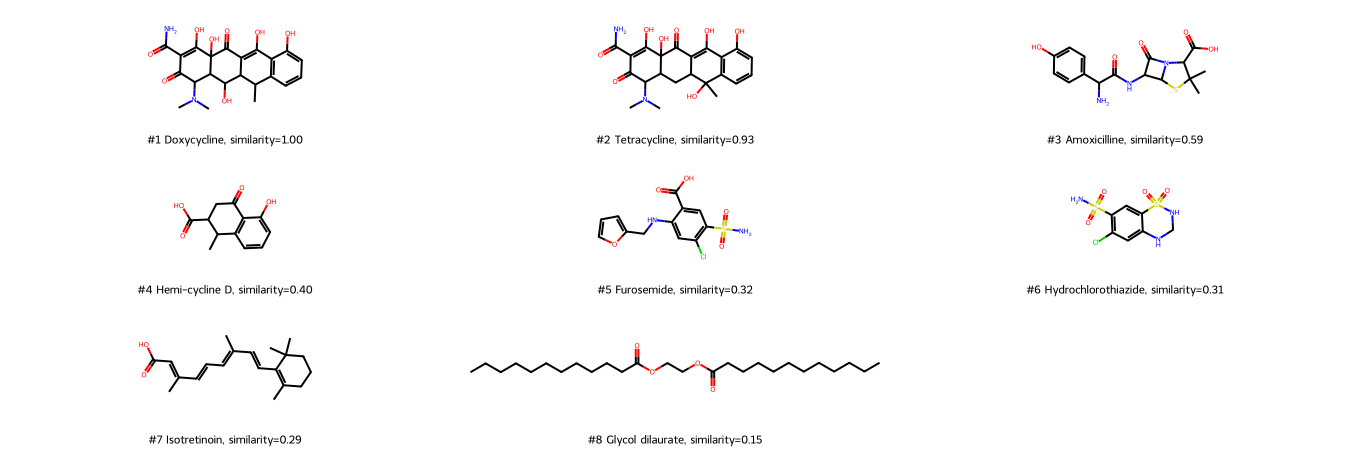

In [19]:
draw_ranked_molecules(molecules, "tanimoto_maccs")

In [ ]:
DataStructs.TanimotoSimilarity(maccs_fp1, maccs_fp2)

- Morgan fingerprints: Tanimoto similarity and Dice similarity

In [20]:
# Define molecule query and list
molecule_query = molecules["morgan"][0]
molecule_list = molecules["morgan"].to_list()
# Calculate similarty values between query and list elements
molecules["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(molecule_query, molecule_list)
molecules["dice_morgan"] = DataStructs.BulkDiceSimilarity(molecule_query, molecule_list)

In [21]:
preview = molecules.sort_values(["tanimoto_morgan"], ascending=False).reset_index()
preview[["name", "tanimoto_morgan", "dice_morgan", "tanimoto_maccs", "dice_maccs"]]
# NBVAL_CHECK_OUTPUT

,name,tanimoto_morgan,dice_morgan,tanimoto_maccs,dice_maccs
0,Doxycycline,1.000000,1.000000,1.000000,1.000000
1,Tetracycline,0.534247,0.696429,0.928571,0.962963
2,Hemi-cycline D,0.308824,0.471910,0.403509,0.575000
3,Amoxicilline,0.144444,0.252427,0.590909,0.742857
4,Furosemide,0.098901,0.180000,0.321839,0.486957
5,Isotretinoin,0.067416,0.126316,0.288136,0.447368
6,Hydrochlorothiazide,0.058824,0.111111,0.306818,0.469565
7,Glycol dilaurate,0.054795,0.103896,0.149254,0.259740


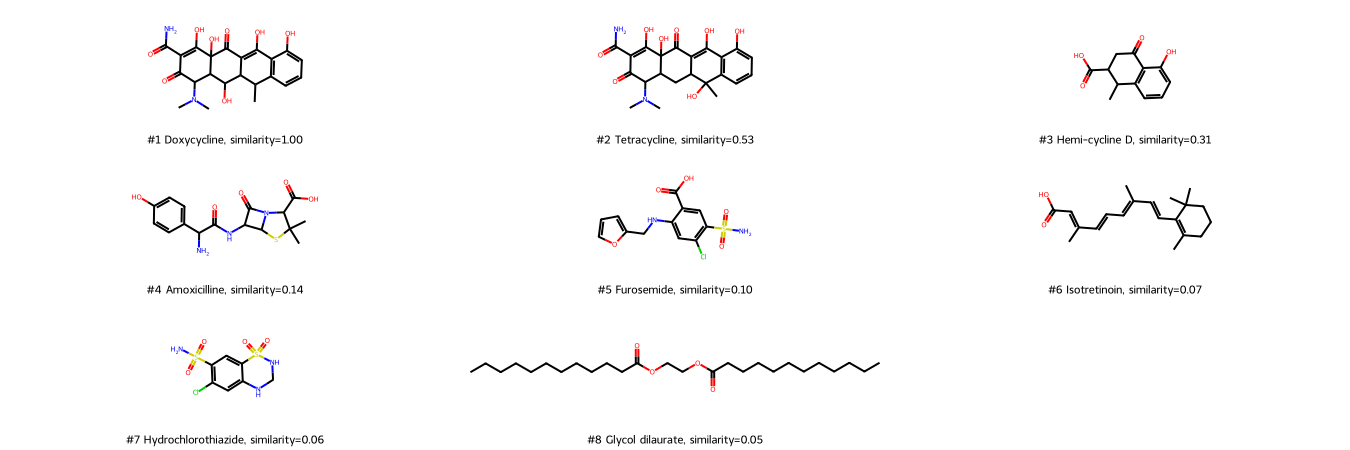

In [22]:
draw_ranked_molecules(molecules, "tanimoto_morgan")

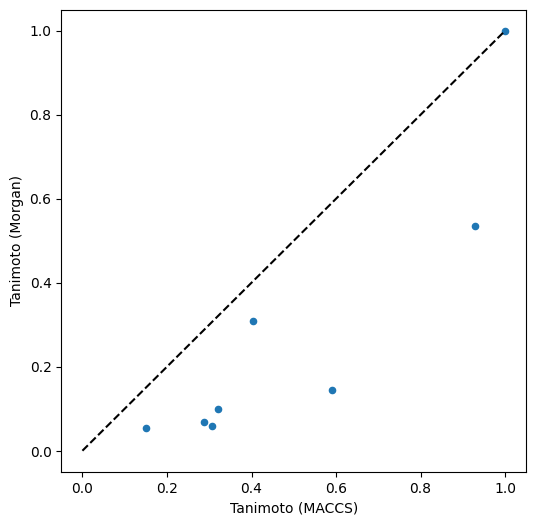

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))
molecules.plot("tanimoto_maccs", "tanimoto_morgan", kind="scatter", ax=ax)
ax.plot([0, 1], [0, 1], "k--")
ax.set_xlabel("Tanimoto (MACCS)")
ax.set_ylabel("Tanimoto (Morgan)")
fig;

## Virtual screening using similarity search



In [24]:
molecule_dataset = pd.read_csv(
    "compounds_lipinski.csv",
    usecols=["molecule_chembl_id", "smiles", "pIC50"],
)
print(f"Number of molecules in dataset: {len(molecule_dataset)}")
molecule_dataset.head(5)

Number of molecules in dataset: 5431


,molecule_chembl_id,smiles,pIC50
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
2,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
3,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910
4,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910


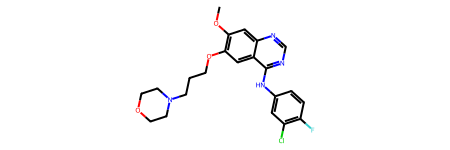

In [25]:
query = Chem.MolFromSmiles("COC1=C(OCCCN2CCOCC2)C=C2C(NC3=CC(Cl)=C(F)C=C3)=NC=NC2=C1")
query

In [27]:
maccs_fp_query = MACCSkeys.GenMACCSKeys(query)
circular_fp_query = fpg.GetCountFingerprint(query)

In [28]:
PandasTools.AddMoleculeColumnToFrame(molecule_dataset, "smiles")
circular_fp_list = molecule_dataset["ROMol"].apply(fpg.GetCountFingerprint).tolist()
maccs_fp_list = molecule_dataset["ROMol"].apply(MACCSkeys.GenMACCSKeys).tolist()

In [29]:
molecule_dataset["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(
    maccs_fp_query, maccs_fp_list
)
molecule_dataset["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(
    circular_fp_query, circular_fp_list
)

In [30]:
molecule_dataset["dice_maccs"] = DataStructs.BulkDiceSimilarity(maccs_fp_query, maccs_fp_list)
molecule_dataset["dice_morgan"] = DataStructs.BulkDiceSimilarity(
    circular_fp_query, circular_fp_list
)

In [31]:
# NBVAL_CHECK_OUTPUT
molecule_dataset[
    ["smiles", "tanimoto_maccs", "tanimoto_morgan", "dice_maccs", "dice_morgan"]
].head(5)

,smiles,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
0,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,0.409836,0.324786,0.581395,0.490323
1,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,0.484375,0.327434,0.652632,0.493333
2,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,0.666667,0.445455,0.800000,0.616352
3,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,0.428571,0.333333,0.600000,0.500000
4,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,0.384615,0.345133,0.555556,0.513158


,molecule_chembl_id,smiles,pIC50,ROMol,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,,0.409836,0.324786,0.581395,0.490323
1,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,,0.484375,0.327434,0.652632,0.493333
2,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,,0.666667,0.445455,0.800000,0.616352

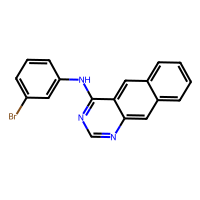
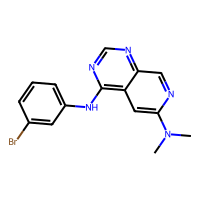
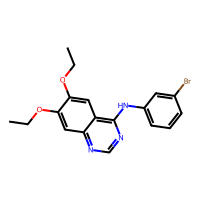

In [32]:
# Show all columns
molecule_dataset.head(3)

- distribution of similarity values

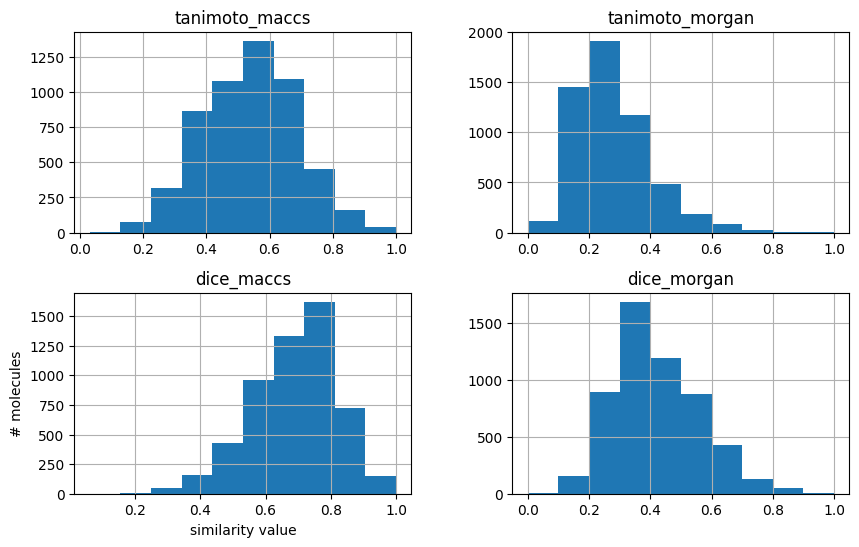

In [33]:
fig, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
molecule_dataset.hist(["tanimoto_maccs"], ax=axes[0, 0])
molecule_dataset.hist(["tanimoto_morgan"], ax=axes[0, 1])
molecule_dataset.hist(["dice_maccs"], ax=axes[1, 0])
molecule_dataset.hist(["dice_morgan"], ax=axes[1, 1])
axes[1, 0].set_xlabel("similarity value")
axes[1, 0].set_ylabel("# molecules")
fig;

- compare similarities: Similarity distributions are important to interpret similarity values, e.g. a value of 0.6 needs to be evaluated differently for MACCS or Morgan fingerprints, as well as Tanimoto or Dice similarities.

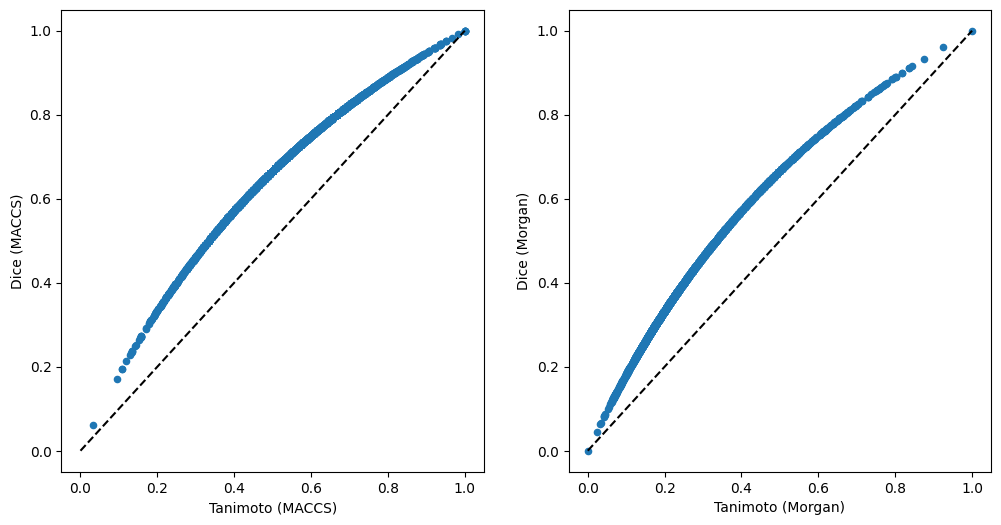

In [34]:
fig, axes = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

molecule_dataset.plot("tanimoto_maccs", "dice_maccs", kind="scatter", ax=axes[0])
axes[0].plot([0, 1], [0, 1], "k--")
axes[0].set_xlabel("Tanimoto (MACCS)")
axes[0].set_ylabel("Dice (MACCS)")

molecule_dataset.plot("tanimoto_morgan", "dice_morgan", kind="scatter", ax=axes[1])
axes[1].plot([0, 1], [0, 1], "k--")
axes[1].set_xlabel("Tanimoto (Morgan)")
axes[1].set_ylabel("Dice (Morgan)")

fig;

- Visualize most similar molecules

,molecule_chembl_id,smiles,pIC50,ROMol,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
3252,CHEMBL939,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1,6.288193,,1.000000,1.000000,1.000000,1.000000
1131,CHEMBL14699,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCN1CCOCC1,8.000000,,1.000000,0.923913,1.000000,0.960452
259,CHEMBL4448162,COc1cc2ncnc(Nc3ccc(Cl)c(Cl)c3)c2cc1OCCCN1CCOCC1,9.000000,,0.983333,0.875000,0.991597,0.933333

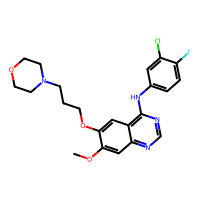
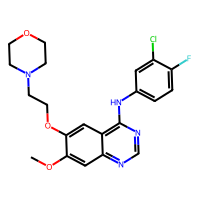
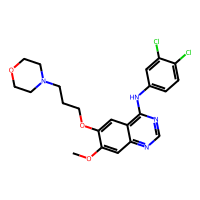

In [35]:
molecule_dataset.sort_values(["tanimoto_morgan"], ascending=False).head(3)

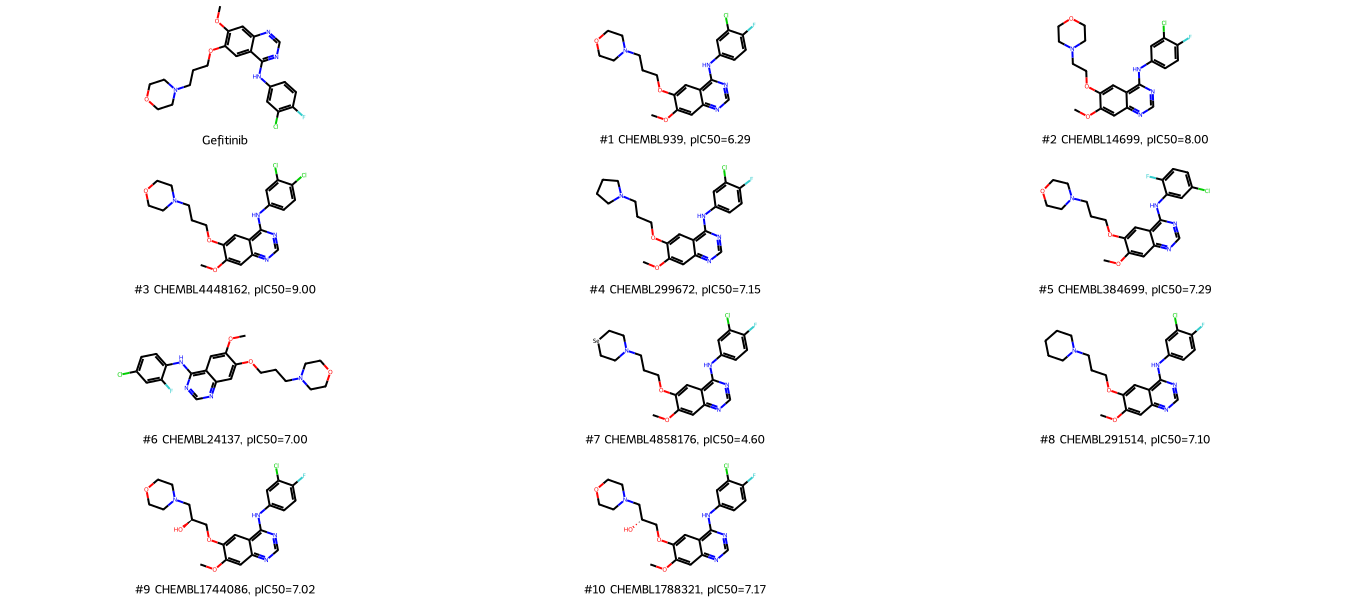

In [36]:
top_n_molecules = 10
top_molecules = molecule_dataset.sort_values(["tanimoto_morgan"], ascending=False).reset_index()
top_molecules = top_molecules[:top_n_molecules]
legends = [
    f"#{index+1} {molecule['molecule_chembl_id']}, pIC50={molecule['pIC50']:.2f}"
    for index, molecule in top_molecules.iterrows()
]
Chem.Draw.MolsToGridImage(
    mols=[query] + top_molecules["ROMol"].tolist(),
    legends=(["Gefitinib"] + legends),
    molsPerRow=3,
    subImgSize=(450, 150),
)

## Generate enrichment plots

In order to validate our virtual screening and see the ratio of detected active molecules, we generate an enrichment plot.
In order to decide whether we treat a molecule as active or inactive, we apply the commonly used pIC50 cutoff value of 6.3. Although there are several suggestions ranging from an pIC50 cutoff values of 5 to 7 in the literature or even to define an exclusion range, we think this cutoff is reasonable. The same cutoff will be used for machine learning

,molecule_chembl_id,smiles,pIC50,ROMol,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,,0.409836,0.324786,0.581395,0.490323
1,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,,0.484375,0.327434,0.652632,0.493333
2,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,,0.666667,0.445455,0.800000,0.616352

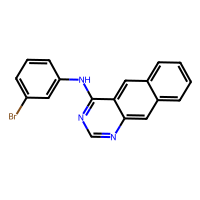
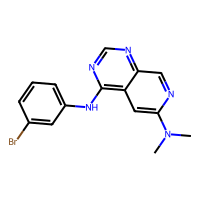
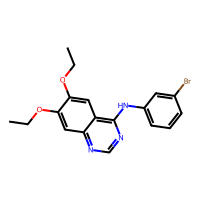

In [38]:
molecule_dataset.head(3)

In [39]:
def get_enrichment_data(molecules, similarity_measure, pic50_cutoff):
    """
    Calculates x and y values for enrichment plot:
        x - % ranked dataset
        y - % true actives identified

    Parameters
    ----------
    molecules : pandas.DataFrame
        Molecules with similarity values to a query molecule.
    similarity_measure : str
        Column name which will be used to sort the DataFrame．
    pic50_cutoff : float
        pIC50 cutoff value used to discriminate active and inactive molecules.

    Returns
    -------
    pandas.DataFrame
        Enrichment data: Percentage of ranked dataset by similarity vs. percentage of identified true actives.
    """

    # Get number of molecules in data set
    molecules_all = len(molecules)

    # Get number of active molecules in data set
    actives_all = sum(molecules["pIC50"] >= pic50_cutoff)

    # Initialize a list that will hold the counter for actives and molecules while iterating through our dataset
    actives_counter_list = []

    # Initialize counter for actives
    actives_counter = 0

    # Note: Data must be ranked for enrichment plots:
    # Sort molecules by selected similarity measure
    molecules.sort_values([similarity_measure], ascending=False, inplace=True)

    # Iterate over the ranked dataset and check each molecule if active (by checking bioactivity)
    for value in molecules["pIC50"]:
        if value >= pic50_cutoff:
            actives_counter += 1
        actives_counter_list.append(actives_counter)

    # Transform number of molecules into % ranked dataset
    molecules_percentage_list = [i / molecules_all for i in range(1, molecules_all + 1)]

    # Transform number of actives into % true actives identified
    actives_percentage_list = [i / actives_all for i in actives_counter_list]

    # Generate DataFrame with x and y values as well as label
    enrichment = pd.DataFrame(
        {
            "% ranked dataset": molecules_percentage_list,
            "% true actives identified": actives_percentage_list,
        }
    )

    return enrichment

In [40]:
pic50_cutoff = 6.3

In [41]:
similarity_measures = ["tanimoto_maccs", "tanimoto_morgan"]
enrichment_data = {
    similarity_measure: get_enrichment_data(molecule_dataset, similarity_measure, pic50_cutoff)
    for similarity_measure in similarity_measures
}

In [42]:
# NBVAL_CHECK_OUTPUT
enrichment_data["tanimoto_maccs"].head()

,% ranked dataset,% true actives identified
0,0.000184,0.000309
1,0.000368,0.000617
2,0.000552,0.000926
3,0.000737,0.001235
4,0.000921,0.001543


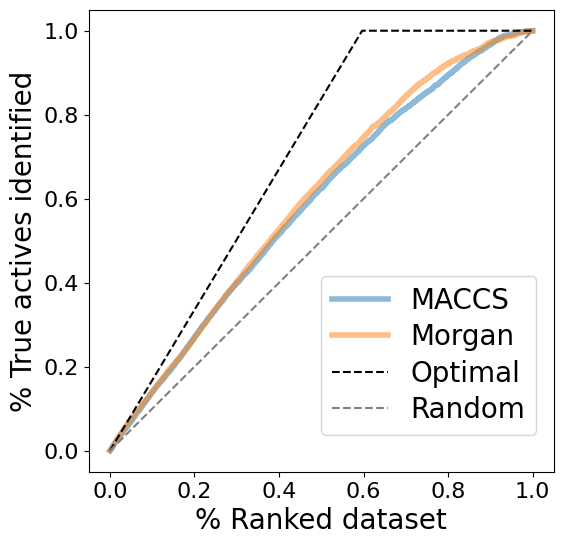

In [43]:
fig, ax = plt.subplots(figsize=(6, 6))

fontsize = 20

# Plot enrichment data
for similarity_measure, enrichment in enrichment_data.items():
    ax = enrichment.plot(
        ax=ax,
        x="% ranked dataset",
        y="% true actives identified",
        label=similarity_measure,
        alpha=0.5,
        linewidth=4,
    )
ax.set_ylabel("% True actives identified", size=fontsize)
ax.set_xlabel("% Ranked dataset", size=fontsize)

# Plot optimal curve: Ratio of actives in dataset
ratio_actives = sum(molecule_dataset["pIC50"] >= pic50_cutoff) / len(molecule_dataset)
ax.plot(
    [0, ratio_actives, 1],
    [0, 1, 1],
    label="Optimal curve",
    color="black",
    linestyle="--",
)

# Plot random curve
ax.plot([0, 1], [0, 1], label="Random curve", color="grey", linestyle="--")

plt.tick_params(labelsize=16)
plt.legend(
    labels=["MACCS", "Morgan", "Optimal", "Random"],
    loc=(0.5, 0.08),
    fontsize=fontsize,
    labelspacing=0.3,
)

# Save plot -- use bbox_inches to include text boxes
plt.savefig(
    "enrichment_plot.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

plt.show()

- calculate enrichment factor

In [44]:
def calculate_enrichment_factor(enrichment, ranked_dataset_percentage_cutoff):
    """
    Get the experimental enrichment factor for a given percentage of the ranked dataset.

    Parameters
    ----------
    enrichment : pd.DataFrame
        Enrichment data: Percentage of ranked dataset by similarity vs. percentage of
        identified true actives.
    ranked_dataset_percentage_cutoff : float or int
        Percentage of ranked dataset to be included in enrichment factor calculation.

    Returns
    -------
    float
        Experimental enrichment factor.
    """

    # Keep only molecules that meet the cutoff
    enrichment = enrichment[
        enrichment["% ranked dataset"] <= ranked_dataset_percentage_cutoff / 100
    ]
    # Get highest percentage of actives and the corresponding percentage of actives
    highest_enrichment = enrichment.iloc[-1]
    enrichment_factor = round(100 * float(highest_enrichment["% true actives identified"]), 1)
    return enrichment_factor

In [45]:
def calculate_enrichment_factor_random(ranked_dataset_percentage_cutoff):
    """
    Get the random enrichment factor for a given percentage of the ranked dataset.

    Parameters
    ----------
    ranked_dataset_percentage_cutoff : float or int
        Percentage of ranked dataset to be included in enrichment factor calculation.

    Returns
    -------
    float
        Random enrichment factor.
    """

    enrichment_factor_random = round(float(ranked_dataset_percentage_cutoff), 1)
    return enrichment_factor_random

In [46]:
def calculate_enrichment_factor_optimal(molecules, ranked_dataset_percentage_cutoff, pic50_cutoff):
    """
    Get the optimal random enrichment factor for a given percentage of the ranked dataset.

    Parameters
    ----------
    molecules : pandas.DataFrame
        the DataFrame with all the molecules and pIC50.
    ranked_dataset_percentage_cutoff : float or int
        Percentage of ranked dataset to be included in enrichment factor calculation.
    activity_cutoff: float
        pIC50 cutoff value used to discriminate active and inactive molecules

    Returns
    -------
    float
        Optimal enrichment factor.
    """

    ratio = sum(molecules["pIC50"] >= pic50_cutoff) / len(molecules) * 100
    if ranked_dataset_percentage_cutoff <= ratio:
        enrichment_factor_optimal = round(100 / ratio * ranked_dataset_percentage_cutoff, 1)
    else:
        enrichment_factor_optimal = 100.0
    return enrichment_factor_optimal

In [47]:
ranked_dataset_percentage_cutoff = 5

In [48]:
for similarity_measure, enrichment in enrichment_data.items():
    enrichment_factor = calculate_enrichment_factor(enrichment, ranked_dataset_percentage_cutoff)
    print(
        f"Experimental EF for {ranked_dataset_percentage_cutoff}% of ranked dataset ({similarity_measure}): {enrichment_factor}%"
    )

Experimental EF for 5% of ranked dataset (tanimoto_maccs): 6.9%
Experimental EF for 5% of ranked dataset (tanimoto_morgan): 7.5%


In [49]:
enrichment_factor_random = calculate_enrichment_factor_random(ranked_dataset_percentage_cutoff)
print(
    f"Random EF for {ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_random}%"
)
enrichment_factor_optimal = calculate_enrichment_factor_optimal(
    molecule_dataset, ranked_dataset_percentage_cutoff, pic50_cutoff
)
print(
    f"Optimal EF for {ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_optimal}%"
)
# NBVAL_CHECK_OUTPUT

Random EF for 5% of ranked dataset: 5.0%
Optimal EF for 5% of ranked dataset: 8.4%
